In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Original dataset
df_orig = pd.read_csv('../content/healthcare-dataset-stroke-data.csv')
y = df_orig['stroke'].copy()
X_orig = df_orig.drop(columns=['stroke'], inplace=False)
num_feat = len(X_orig.columns) 
num_obj = len(X_orig)
# Cross-validator
cv = KFold(n_splits=5, shuffle=True, random_state=42)
X_orig.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


Text(0.5, 1.0, 'Pie chart of the "stroke" column\n     "1" $-$ patient had a stroke,\n     "0" $-$ patient did not have a stroke')

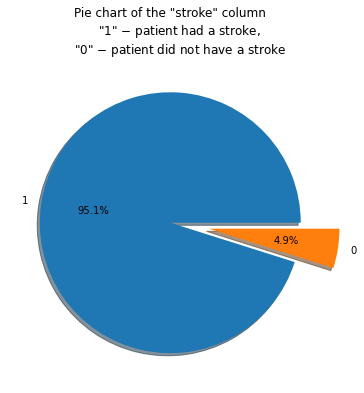

In [ ]:
# Stroke pie chart
plt.figure(figsize=(10, 6))
plt.pie(y.value_counts(), labels=['1', '0'], autopct='%.1f%%', shadow=True, explode=(0, 0.3));  
plt.title('Pie chart of the "stroke" column\n \
    "1" $-$ patient had a stroke,\n \
    "0" $-$ patient did not have a stroke')

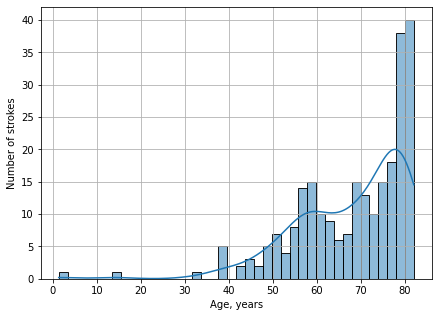

In [ ]:
# Stroke от age
plt.figure(figsize=(7, 5))
age_stroke = X_orig['age'].loc[y==1]
sns.histplot(x=age_stroke, bins=40, kde=True)
plt.xlabel('Age, years')
plt.ylabel('Number of strokes')
plt.grid()

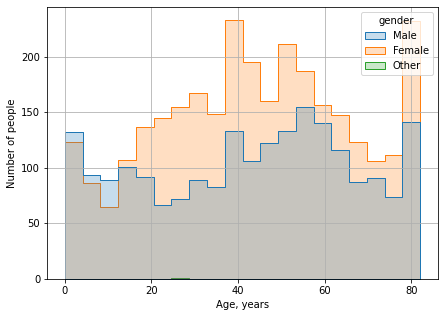

In [ ]:
# Age distribution
plt.figure(figsize=(7, 5))
sns.histplot(x=X_orig['age'], hue=X_orig['gender'], element='step', legend=True)
plt.xlabel('Age, years')
plt.ylabel('Number of people')
plt.grid()

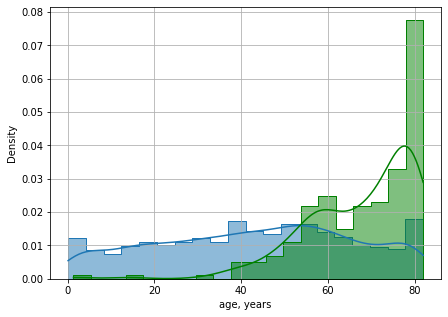

In [ ]:
age_stroke = X_orig['age'].loc[y==1]
fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(x=X_orig['age'], ax=ax, stat='density', kde=True, element='step')
sns.histplot(x=age_stroke, ax=ax, bins=20, stat='density', kde=True, element='step', color='g')
ax.set_xlabel('age, years')
ax.grid()

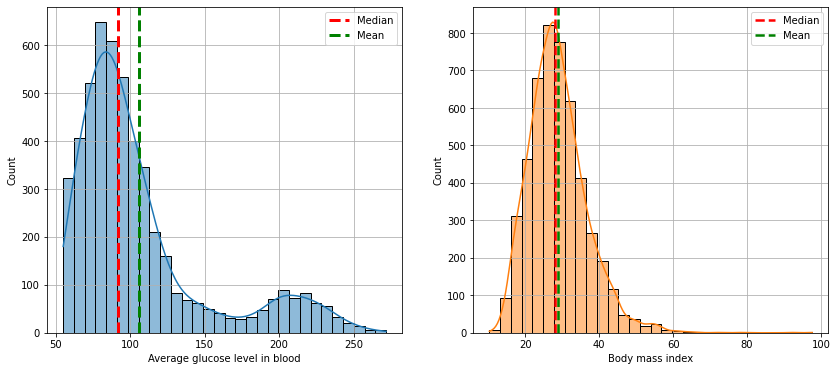

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Glucose
sns.histplot(X_orig['avg_glucose_level'], ax=ax[0], bins=30, kde=True)
ax[0].set_xlabel('Average glucose level in blood')
ax[0].axvline(X_orig['avg_glucose_level'].median(), label='Median', linestyle='--', color='r', lw=3)
ax[0].axvline(X_orig['avg_glucose_level'].mean(), label='Mean', linestyle='--', color='g', lw=3)
ax[0].legend()
ax[0].grid()
# BMI
sns.histplot(x=X_orig['bmi'], ax=ax[1], bins=30, kde=True, color='tab:orange')
ax[1].set_xlabel('Body mass index')
ax[1].axvline(X_orig['bmi'].median(), label='Median', linestyle='--', color='r', lw=2.5)
ax[1].axvline(X_orig['bmi'].mean(), label='Mean', linestyle='--', color='g', lw=2.5)
ax[1].legend()
ax[1].grid()

Text(0, 0.5, 'Smoking status')

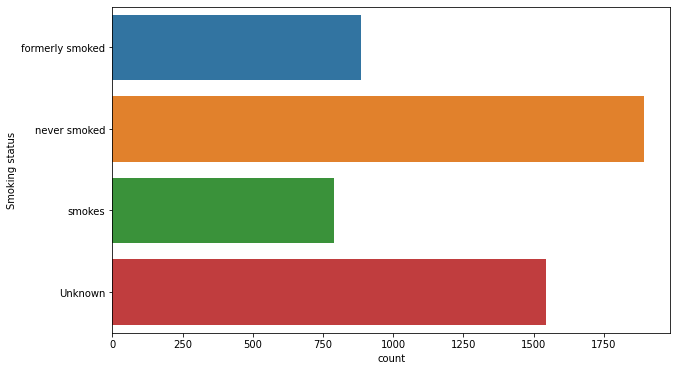

In [ ]:
# Smoking status
plt.figure(figsize=(10, 6))
sns.countplot(y=X_orig['smoking_status'])
plt.ylabel('Smoking status')

Text(0.5, 1.0, '"1" $-$ patient has hypertension,\n     "0" $-$ patient does not have hypertension')

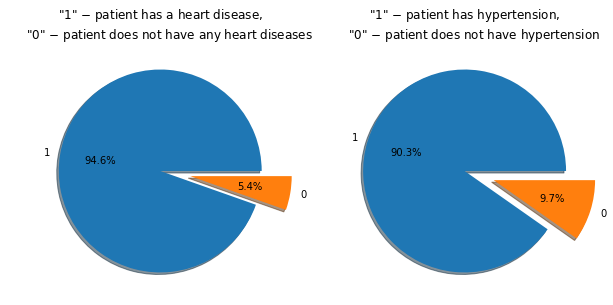

In [ ]:
fig, ax  = plt.subplots(1, 2, figsize=(10, 6))
ax[0].pie(X_orig['heart_disease'].value_counts(), labels=['1', '0'], autopct='%.1f%%', shadow=True, explode=(0, 0.3));  
ax[0].set_title('"1" $-$ patient has a heart disease,\n \
    "0" $-$ patient does not have any heart diseases')
ax[1].pie(X_orig['hypertension'].value_counts(), labels=['1', '0'], autopct='%.1f%%', shadow=True, explode=(0, 0.3));  
ax[1].set_title('"1" $-$ patient has hypertension,\n \
    "0" $-$ patient does not have hypertension')

In [ ]:
def ohe(df, features):
    """
    one-hot enccoder.
    df -- input DataFrame
    features -- list of features to be encoded

    One can easily use sklearn.preprocessing.OneHotEncoder instead
    """
    for feat in features:
        categ_list = df[feat].unique()
        df_enc = np.zeros((df.shape[0], len(categ_list)))
        for ii in range(len(categ_list)):
            df_enc[:, ii] = (df[feat]==categ_list[ii]).astype(int) 

        df_enc = pd.DataFrame(data=df_enc, index=df.index, columns=categ_list)
        df = pd.concat([df, df_enc], axis=1)
    return df

X_prep = X_orig.copy()
# Encode categorial features
# Male - 1, Female - 0
X_prep['gender'] = X_prep['gender'].map({'Male': 1, 'Female': 0, 'Other': 1})
# urban - 1, rural - 0
X_prep['Residence_type'] = X_prep['Residence_type'].map({'Urban': 1, 'Rural': 0})
# ever_married yes - 1, no - 0
X_prep['ever_married'] = X_prep['ever_married'].map({'Yes': 1, 'No': 0})
# One-hot encoder for work_type, smoking_status
X_prep = ohe(X_prep, ['work_type', 'smoking_status'])
X_prep.drop(columns=['work_type', 'smoking_status'], inplace=True)
# Fill the NaN in BMI column
X_prep['bmi'].fillna(X_prep['bmi'].median(), inplace=True)
# Scaling
scaler = StandardScaler()
X_prep = pd.DataFrame(data=scaler.fit_transform(X_prep), index=X_prep.index, columns=X_prep.columns)

In [ ]:
C_regul = [0.01, 0.1, 1]
for regul in C_regul:
    clf = LogisticRegression(penalty='l2', C=regul).fit(X_prep, y)
    print('Cross-validation score: %f' % 
          cross_val_score(clf, X_prep, y, cv=cv, scoring='roc_auc').mean())

Cross-validation score: 0.834009
Cross-validation score: 0.841548
Cross-validation score: 0.841832


In [ ]:
# Find the best value for C regularization parameter
grid_linear = {'C': [0.0001]}
grid_poly = {'C': [0.01, 0.1, 1], 'gamma': [0.001, 0.01, 0.1], 'coef0': [3, 4]}
grid_rbf = {'C': [0.1, 1], 'gamma': [0.001, 0.01, 0.1]}
grid_sigmoid = {'C': [0.001, 0.01, 0.1], 'gamma': [0.0001, 0.01], 'coef0': [1, 10]}
grids = [grid_linear, grid_poly, grid_rbf, grid_sigmoid]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
params = []
scores = []
for ind, kern in enumerate(kernels):
    svc_clf = SVC(kernel=kern)
    gs = GridSearchCV(estimator=svc_clf, param_grid=grids[ind], cv=cv, scoring='roc_auc')
    gs.fit(X_prep, y)
    params.append(gs.best_params_)
    scores.append(gs.best_score_)
    print(kern, gs.best_params_, gs.best_score_)
params_best = params[np.argmax(scores)]
kern_best = kernels[np.argmax(scores)]
print('Best parameters: kernel = %s, C = %f, coef0 = %f, gamma = %f' % 
      (kern_best, params_best['C'], params_best['coef0'], params_best['gamma']))

linear {'C': 0.0001} 0.6719682585842637
poly {'C': 1, 'coef0': 4, 'gamma': 0.001} 0.6664558183391293
rbf {'C': 1, 'gamma': 0.1} 0.6504383290117437
sigmoid {'C': 0.001, 'coef0': 10, 'gamma': 0.01} 0.801996646412347
Best parameters: kernel = sigmoid, C = 0.001000, coef0 = 10.000000, gamma = 0.010000


In [ ]:
clf_svm = SVC(C=params_best['C'], 
              kernel=kern_best, 
              coef0=params_best['coef0'], 
              gamma=params_best['gamma']).fit(X_prep, y)
print('Cross-validation score: %f' % 
          cross_val_score(clf_svm, X_prep, y, cv=cv, scoring='roc_auc').mean())

Cross-validation score: 0.801997


In [ ]:
X_tree = X_orig.copy()
# Encode categorial features
# Male - 1, Female - 0
X_tree['gender'] = X_tree['gender'].map({'Male': 1, 'Female': 0, 'Other': 1})
# urban - 1, rural - 0
X_tree['Residence_type'] = X_tree['Residence_type'].map({'Urban': 1, 'Rural': 0})
# ever_married yes - 1, no - 0
X_tree['ever_married'] = X_tree['ever_married'].map({'Yes': 1, 'No': 0})
# One-hot encoder for work_type, smoking_status
X_tree = ohe(X_tree, ['work_type', 'smoking_status'])
X_tree.drop(columns=['work_type', 'smoking_status'], inplace=True)
# Fill the NaN in BMI column
X_tree['bmi'].fillna(X_tree['bmi'].median(), inplace=True)
# We do not need to scale our data for decision tree algorithm

In [ ]:
clf_tree = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.003)
clf_tree.fit(X_tree, y)
print('Cross-validation score: %f' % cross_val_score(clf_tree, X_tree, y, cv=cv, scoring='roc_auc').mean())

Cross-validation score: 0.822071


In [ ]:
# Find the best parameters
# Actually, KNN is quite bad with highly unbalanced classes.
# One should use some oversampling technique first, e.g. SMOTE (TODO)
grid = {'n_neighbors': [50, 75, 100], 'p': [1, 3, 5]}

clf_knn = KNeighborsClassifier(weights='distance', metric='minkowski')
gs = GridSearchCV(estimator=clf_knn, param_grid=grid, cv=cv, scoring='roc_auc')
gs.fit(X_prep, y)
print('Best parameters: n_neighbors = %d, p = %d' % (gs.best_params_['n_neighbors'], gs.best_params_['p']))

Best parameters: n_neighbors = 75, p = 1


In [ ]:
# Use the best parameters in the model
clf_knn = KNeighborsClassifier(weights='distance', metric='minkowski', 
                               n_neighbors=gs.best_params_['n_neighbors'], 
                               p=gs.best_params_['p'])
print('Cross-validation score: %f' % cross_val_score(clf_knn, X_prep, y, cv=cv, scoring='roc_auc').mean())

Cross-validation score: 0.774600


In [ ]:
clf_bayes = GaussianNB().fit(X_prep, y)
print('Cross-validation score: %f' % cross_val_score(clf_bayes, X_prep, y, cv=cv, scoring='roc_auc').mean())

Cross-validation score: 0.800360


In [ ]:
X_forest = X_orig.copy()
# Encode categorial features
# Male - 1, Female - 0
X_forest['gender'] = X_forest['gender'].map({'Male': 1, 'Female': 0, 'Other': 1})
# urban - 1, rural - 0
X_forest['Residence_type'] = X_forest['Residence_type'].map({'Urban': 1, 'Rural': 0})
# ever_married yes - 1, no - 0
X_forest['ever_married'] = X_forest['ever_married'].map({'Yes': 1, 'No': 0})
# One-hot encoder for work_type, smoking_status
X_forest = ohe(X_forest, ['work_type', 'smoking_status'])
X_forest.drop(columns=['work_type', 'smoking_status'], inplace=True)
# Fill the NaN in BMI column
X_forest['bmi'].fillna(X_forest['bmi'].median(), inplace=True)

In [ ]:
# Find the best parameters
grid = {'n_estimators': [20, 50, 100, 200], 'ccp_alpha': [0.0, 0.01, 0.1], 'max_depth': [4, 5, 6]}
clf_forest = RandomForestClassifier(criterion='entropy',
                    max_features='auto')
gs = GridSearchCV(clf_forest, param_grid=grid, cv=cv, scoring='roc_auc')
gs.fit(X_forest, y)
print('Best parameters: n_estimators = %d, ccp_alpha = %f, max_depth = %d' % 
      (gs.best_params_['n_estimators'], gs.best_params_['ccp_alpha'], gs.best_params_['max_depth']))

Best parameters: n_estimators = 100, ccp_alpha = 0.000000, max_depth = 6


In [ ]:
# Use the best parameters in the model
clf_forest = RandomForestClassifier(criterion='entropy', max_features='auto',
                                   n_estimators=gs.best_params_['n_estimators'],
                                   ccp_alpha=gs.best_params_['ccp_alpha'],
                                   max_depth=gs.best_params_['max_depth'])
print('Cross-validation score: %f' % cross_val_score(clf_forest, X_forest, y, cv=cv, scoring='roc_auc').mean())

Cross-validation score: 0.839115
